# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [4]:
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
import os
load_dotenv(r"H:\My_LangGraph_toturial\.env")

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = os.getenv(var)
        print("var" , var)
        print("key" , os.getenv(var))
_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [5]:

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [6]:
from langchain_openai import ChatOpenAI
llm : ChatOpenAI = ChatOpenAI(model_name="gpt-3.5-turbo-0125",max_tokens=20, temperature=0)
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several other fascinating ocean mammals that you could research. Some examples include', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 39, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-fdca91a0-8d56-47e1-897d-3a2ff59e9cef-0', usage_metadata={'input_tokens': 39, 'output_tokens': 20, 'total_tokens': 59, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

We can run our chat model in a simple graph with `MessagesState`.

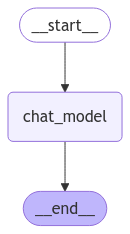

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals that you could research. Some examples include


In [9]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      # on_chain_start = start of a node execution
        # on_chain_end = end of a node execution
      #on_chain_stream = Represent intermediate state of a node execution
      print("\n--------------\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='08374432-7247-4192-be98-09f9457aa4e9'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='668a478f-635c-4c2b-b029-80777643e448')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'faf48d84-6bcb-44b3-ba6d-0669868997e6', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='08374432-7247-4192-be98-09f9457aa4e9'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='668a478f-635c-4c2b-b029-80777643e448')]}}, 'name': '__start__', '

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

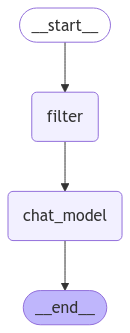

In [10]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState) -> MessagesState:
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals that you could research. Some examples include


## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

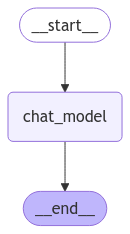

In [12]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [13]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [14]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals that you could research. Some examples include
================================ Human Message =================================
Name: Lance

Tell me more about Narwhals!


In [31]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating creatures.  But the world of ocean mammals goes way beyond whales! Here are some others to dive into:

**Marine Mammals:**

* **Dolphins:** These intelligent and social creatures are found in all oceans.  There are over 40 different species, each with unique characteristics and behaviors.
* **Porpoises:**  Often confused with dolphins, porpoises are smaller, stockier, and have a triangu

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

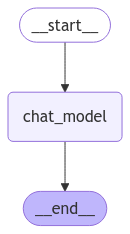

In [20]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [19]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False
        )

[AIMessage(content='In addition to whales, there are several other fascinating ocean mammals that you could research. Some examples include', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 39, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-403e4937-d65f-4ed3-b857-c1c24d514a79-0', usage_metadata={'input_tokens': 39, 'output_tokens': 20, 'total_tokens': 59, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(content='Tell me more about Narwhals!', additional_kwargs={}, response_metadata={}, name='Lance', id='c7fb1456-5551-41ee-b3e4-74524e3b39ad'),
 AIMessage(c

In [18]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

NameError: name 'ChatGoogleGenerativeAI' is not defined

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r